In [1]:
#magic functions
%load_ext autoreload
%autoreload 2

#imports
from helpers import *

#plotting
import matplotlib.pyplot as plt

#math
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import random

#louvian clustering
import networkx as nx
import community
import community.community_louvain as community_louvain

#Maximum likelyhood clustering
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

#Portfolio optimization (Markovitz)
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [2]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut = drop_nans(DF)

DF = DF_cut

display(DF.head(5))

,^GSPC,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,...,NBL,MAT,JCP,AVT,THC,GRA,LPX,VLO,WMB,TXI
8033,-0.022160,0.000000,-0.022696,0.000000,-0.030214,-0.006135,-0.013606,-0.029414,-0.026387,0.000000,...,-0.024693,-0.047791,0.00000,-0.010292,0.006810,0.000000,0.000000,-0.012270,-0.048790,-0.003431
8034,-0.007273,-0.021506,-0.004313,-0.012739,0.000000,-0.003082,-0.006873,-0.015038,-0.005362,0.000000,...,-0.051293,0.000000,0.00000,-0.003454,-0.034526,0.000000,-0.005970,-0.063716,-0.025318,-0.006897
8035,-0.002100,0.021506,0.000000,-0.012903,-0.012346,0.006154,-0.006920,0.029853,-0.005391,0.030772,...,-0.042233,0.106060,0.02353,0.005177,-0.007051,0.000000,0.011905,-0.026668,0.000000,-0.006944
8036,0.005200,0.000000,0.000000,0.000000,0.000000,0.006116,0.006920,0.057158,0.000000,0.029853,...,0.007813,0.043084,0.00000,-0.005177,0.007051,0.000000,-0.023953,0.013423,0.000000,0.006944
8037,-0.023443,-0.021506,0.000000,-0.039740,-0.031548,-0.024693,-0.013889,-0.064539,-0.021859,-0.029853,...,-0.027615,-0.062132,-0.02353,0.000000,-0.029711,-0.287682,-0.018349,-0.068993,-0.052644,-0.013938


## Louvain clustering

In [3]:
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)
    
    # TO CHECK: WHY N-1?!?!? isn't range enough to stop at N-1?!
    # _s stands for _structure below: 
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    

In [4]:
def LouvainCorrelationClustering(R):   # R is a matrix of return
    """Given a retun matrix performs Louvain Correlation Clustering"""
    N=R.shape[1]
    T=R.shape[0]
    
    #Perform Louvain Correlation Clustering
    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
      
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)

    df=pd.DataFrame.from_dict(partition,orient="index")
    
    #Rewrite results in a nice format
    df['StockName'] = R.columns
    df = df.reset_index()
    df = df.drop(columns = 'index')
    df = df.rename({0: 'Cluster'},axis = 'columns')
    df = df.set_index('StockName')
    
    return(df)

In [5]:
clust_louvain=LouvainCorrelationClustering(DF_cut)
display(clust_louvain.head(5))

,Cluster
StockName,
^GSPC,0
GE,1
IBM,0
DIS,0
BA,2


## Maximum likelihood clustering


There is no code for this method in Python. The following shows how to call R from Python.

### If It's the first time you use rpy2 then you need to:
1) install R https://cran.rstudio.com/
2) run: !pip install rpy2


In [6]:
# Run only once!!!
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages("data.table")

--- Per piacere, seleziona un mirror CRAN per la sessione ---


From cffi callback <function _consolewrite_ex at 0x00000158E3818D38>:
Traceback (most recent call last):
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 78: invalid continuation byte
R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/bin/windows/contrib/4.1/data.table_1.14.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2600662 bytes (2.5 MB)

R[write to console]: downloaded 2.5 MB




package 'data.table' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mauro\AppData\Local\Temp\Rtmpsz97Qy\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x00000158E3A07BC8> [RTYPES.NILSXP]

In [7]:
#From r package import a python function aggregateClusters able to perform maximum likelyhood clustering
r = robjects.r
rpy2.robjects.numpy2ri.activate()
importr("data.table")
newfunc = r.source("libClusteringGiadaMarsiliFast.R")
aggregateClusters=robjects.globalenv["aggregateClusters"]

In [8]:
def aggregateClusters_(R,aggregateClusters=aggregateClusters):
    """Slight modification to the original function taken from "libClusteringGiadaMarsiliFast.R" package.
    The modification is made in order to simplify the use and to produce the output with the same format as
    the previous clustering method"""
    C = R.corr()
    intermediate_result = aggregateClusters(C.values)
    nb_clusters = len(intermediate_result[3])
    ls_dfs = []
    for i in range(nb_clusters):
        df = pd.DataFrame(np.array(intermediate_result[3][i]),columns = ['Stock Name'])
        df['Cluster'] = i
        ls_dfs.append(df)
    df = pd.concat(ls_dfs)
    df['StockName'] = R.columns
    df = df.reset_index()
    df = df.drop(columns = 'index')
    df = df.drop(columns = 'Stock Name')
    df = df.rename({0: 'Cluster'},axis = 'columns')
    df = df.set_index('StockName')

    return df

In [9]:
print('Max Likelyhood Clustering output:')
display(aggregateClusters_(DF_cut))
print('-------------------------------------------------------------------')
print('Louvain Correlation Clustering output:')
display(LouvainCorrelationClustering(DF_cut))

Max Likelyhood Clustering output:


,Cluster
StockName,
^GSPC,0
GE,0
IBM,0
DIS,0
BA,0
...,...
GRA,13
LPX,14
VLO,15


-------------------------------------------------------------------
Louvain Correlation Clustering output:


,Cluster
StockName,
^GSPC,0
GE,1
IBM,0
DIS,0
BA,4
...,...
GRA,3
LPX,3
VLO,1


## Comparaison of performance of different techniques to create portfolio
To create a portfolio starting from a set of data indicating the returns of various stocks, proceed as follows:
You decide whether you want to cluster or not. If you want, you can decide on one of the two methods, either maximum likelihood or Louvian clustering.
If you have decided to perform clustering you must also decide on 2 aggregation techniques: 
1. an intra_cluster technique and an iter_cluster technique. The first technique will be used within the cluster to decide how much weight to give to each stock. In this way we form a portfolio for each cluster which will then be used as if it were a single stock.
2. These 'single stocks' are then aggregated using the inter_cluster technique.

Note that for the various weight balancing techniques within the portfolio it is possible to choose between:
1. An equal weights tecnique where all the stocks are given the same weight.
2. An inverse std tecnique where all the stocks are given a weight inversly proportional to their standard deviation (risk).
3. A markovitz tecnique where all the stocks are given a weight found via a classic markovitz optimized portfolio. We can contraint the portfolio by limiting the bounds values for weights. 
Lastly We can decide not to perform clustering and to only use markovitz tecnique on the full data instead that on the clusters.

In [11]:
def optimalWeights(df,verbose = False,shortBan = True):
    """use pypfopt to compute the optimal weights of the portfolio following markovitz strategy"""
    #compute expected_returns and covariance matrix 
    mu = expected_returns.mean_historical_return(df,returns_data=True,log_returns =True)
    S = risk_models.sample_cov(df,returns_data=True,log_returns =True)
    
    if shortBan:
        #By default the ef is long only 
        ef = EfficientFrontier(mu, S)
        
    else:
        #Allow negative weights => No shortBan
        #We could limit the maxweight just by changing the bounds 
        #ex: max 10% with shortban weight_bounds=(0, 0.1)
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        
    
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if verbose:
        return ef.portfolio_performance()
    return cleaned_weights

def weight_inverse_std(df):
    """Helper function for the inner-cluster aggregation using inverse std technique.
    Given a df containing all data of a cluster rescale the value of returns of each stock
    taking as weight the sum(std)/std then aggregate all the returns toghether. 
    The following methods will use this portfolio of clustered stocks as a single 
    stock and compose a portfolio"""
    #save cluster and drop it
    cluster = df['Cluster'].iloc[0]
    df = df.drop(columns = ['Cluster']).transpose()
    #compute sum of all std in the currrent cluster
    sum_stds = 0
    for col in df.columns:
        if col != 'Cluster':
            inv_sum_stds += (1/df[col].std())
    #rescale every column with weight = current (1/std)/ sum all(1/std)
    for col in df.columns:
        if col != 'Cluster':
            df[col] = df[col]*/(df[col].std()*inv_sum_stds)
    df = df.sum(axis = 1)
    df = df.transpose()
    #put back the cluster to the df
    df['Cluster'] = cluster
    return df

def compute_clusters_returns(df,clusters,intra_cluster_strategy = 'equal weight'):
    """given a dataframe and his clusters compute the clusters means"""
    
    if intra_cluster_strategy == 'equal weight':
        #transpose in order to have the clusters as a feature allowing groupBy
        means = df.transpose()
        #add cluster info for groupBy
        means = pd.merge(means, clusters,left_index = True, right_on='StockName')
        #compute the mean of each group and transpose-back the matrix
        means = means.groupby('Cluster').mean().transpose()
        
    elif intra_cluster_strategy == 'inverse std':
        #transpose in order to have the clusters as a feature allowing groupBy
        dftr = df.transpose()
        #add cluster info for groupBy
        dftr = pd.merge(dftr, clusters,left_index = True, right_on='StockName')
        #groupBy using helperfunction: rescale using the inv std then taking the sum
        means = dftr.groupby('Cluster').apply(lambda x: weight_inverse_std(x))
        #drop unecessary column and transpose to have a coherent return format
        means = means.drop(columns = ['Cluster']).transpose()
        
    return means

def compute_portfolio_return(df,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight'):
    """given a dataframe, a clustering method and a portfolio weighting strategy
    compute the return of the portfolio composed by appling clustering than combining
    the clusters using the strategy"""
    if inter_cluster_strategy == 'equal weight':
        
        #clustering
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
         
        #compute portfolio performance
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        
        #compute daily risk and expected returns
        portfolio_mean = cluster_means.mean().mean()
        portfolio_std = cluster_means.mean(axis = 1).std()
        #rescale to yearly risk and expected returns (Note that they are log-scaled)
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        return portfolio_mean,portfolio_std,SharpR
        
    elif inter_cluster_strategy == 'inverse std':
        
        #clustering
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
            
        #compute portfolio performance       
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        cluster_std = cluster_means.std()
        #Computing portfolio returns using inverse std intercluster strategy
        weights = np.array([ i/sum(list(cluster_std)) for i in list(cluster_std)]).T
        portfolio_mean = (np.array(cluster_means)@weights).mean()
        portfolio_std = (np.array(cluster_means)@weights).std()
        #rescale to yearly risk and expected returns (Note that they are log-scaled)
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        return portfolio_mean,portfolio_std,SharpR
        
    elif inter_cluster_strategy == 'markovitz':
        if clustering == 'NO clustering':
            #no clustering only markovitz portfolio
            portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
            return portfolio_mean,portfolio_std,SharpR
        
        #clustering
        elif clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
        
        #compute portfolio performance using markovitz weight optimization
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
        return portfolio_mean,portfolio_std,SharpR
             
def compute_stategy_avg_return(df,n,n_picks,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight'):
    """given a dataframe, a number of picks, a size n, a clustering method and a portfolio weighting strategy
    compute the average return of n_picks portfolios composed picking at random n stocks from the df,
    applying clustering and combining with the weight strategy"""
    portfolio_returns = []
    portfolio_risks = []
    portfolio_sharpRs = []
    
    for i in range(n_picks):
        #randomly sub-sampling the df
        sub_df = pick_n_from_k(df,n,seed = (i+1))
        #compute the performance of the method on the current sub_df 
        portfolio_return,portfolio_risk,SharpR = compute_portfolio_return(sub_df,clustering = clustering,inter_cluster_strategy =inter_cluster_strategy,intra_cluster_strategy = intra_cluster_strategy)
        print('portfolio nb: ',i, 'return: ',portfolio_return)
        #save results
        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_risk)
        portfolio_sharpRs.append(SharpR)
        
    #Plot mean with bootstrapping confidence interval
    portfolio_returns_mean = sum(portfolio_returns)/len(portfolio_returns)
    CI = bootstrap_CI(portfolio_returns,int(n_picks/1.5))
    yerr = [-(CI[0]-portfolio_returns_mean),CI[1]-portfolio_returns_mean]
    plt.errorbar(1,portfolio_returns_mean,yerr = np.array(yerr).reshape(2,1), fmt='.', ecolor = 'red')
    plt.ylabel("Mean return of clustering method :" + clustering +' intra ' + intra_cluster_strategy +' inter ' + inter_cluster_strategy)
    plt.title("Mean return of clustering method with confidence intervals")
    return portfolio_returns,portfolio_risks,portfolio_sharpRs

strategy mean: 
portfolio nb:  0 return:  0.1200007601897759
portfolio nb:  1 return:  0.12108913374004548
portfolio nb:  2 return:  0.13217982253269867
portfolio nb:  3 return:  0.12075074630855243
portfolio nb:  4 return:  0.113156204822352
portfolio nb:  5 return:  0.129663231149026
portfolio nb:  6 return:  0.12997140107012228
portfolio nb:  7 return:  0.1271659731690855
portfolio nb:  8 return:  0.12404976857314343
portfolio nb:  9 return:  0.12097813708065197


([0.1200007601897759,
  0.12108913374004548,
  0.13217982253269867,
  0.12075074630855243,
  0.113156204822352,
  0.129663231149026,
  0.12997140107012228,
  0.1271659731690855,
  0.12404976857314343,
  0.12097813708065197],
 [16.414386701561813,
  19.916521133763712,
  15.805199761977118,
  15.54059459765205,
  16.607822935051274,
  15.492068142889249,
  17.187474811660977,
  16.684633141591064,
  16.020282323087265,
  16.86563394556451],
 [0.00731070629512816,
  0.006079833567658949,
  0.008363059279433233,
  0.007770020995644275,
  0.006813427940849048,
  0.00836965277670435,
  0.007561983508010273,
  0.0076217422396953486,
  0.007743294785409114,
  0.0071730560185950185])

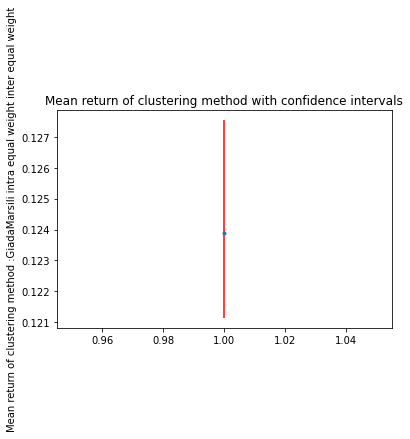

In [12]:
print('strategy mean: ')
compute_stategy_avg_return(DF,65,10,clustering = 'GiadaMarsili')

portfolio nb:  0 return:  0.12637960062385645
portfolio nb:  1 return:  0.11810844826063782
portfolio nb:  2 return:  0.14706160838893623
portfolio nb:  3 return:  0.13538660731143448
portfolio nb:  4 return:  0.13108164630015584
portfolio nb:  5 return:  0.134883335237447
portfolio nb:  6 return:  0.13122635696519347
portfolio nb:  7 return:  0.13231161538231873
portfolio nb:  8 return:  0.13360769771236192
portfolio nb:  9 return:  0.1308447821469192
strategy inv std:  ([0.12637960062385645, 0.11810844826063782, 0.14706160838893623, 0.13538660731143448, 0.13108164630015584, 0.134883335237447, 0.13122635696519347, 0.13231161538231873, 0.13360769771236192, 0.1308447821469192], [14.722878754348997, 16.48743912871731, 13.833764933321627, 13.632121163894226, 14.436617859268786, 13.566603102032142, 13.865027763511518, 14.809355446394035, 13.771111329067024, 14.682559919808913], [0.008583891963827056, 0.007163541125978758, 0.010630627966990129, 0.009931441019613062, 0.00907980301050894, 0.0

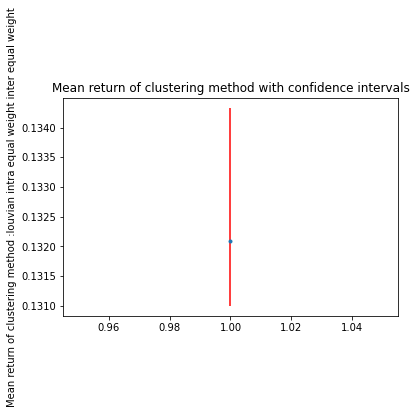

In [13]:
print('strategy inv std: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

portfolio nb:  0 return:  0.12461577718405947
portfolio nb:  1 return:  0.12139892373580086
portfolio nb:  2 return:  0.14706160838893623
portfolio nb:  3 return:  0.13551095759510434
portfolio nb:  4 return:  0.13415715947271334
portfolio nb:  5 return:  0.134883335237447
portfolio nb:  6 return:  0.1353595711686839
portfolio nb:  7 return:  0.13231161538231873
portfolio nb:  8 return:  0.13360769771236192
portfolio nb:  9 return:  0.1308447821469192
strategy mean:  ([0.12461577718405947, 0.12139892373580086, 0.14706160838893623, 0.13551095759510434, 0.13415715947271334, 0.134883335237447, 0.1353595711686839, 0.13231161538231873, 0.13360769771236192, 0.1308447821469192], [15.350836516530645, 17.494565718086793, 13.833764933321627, 13.681713635956891, 13.96431786688257, 13.566603102032142, 13.47657292068975, 14.809355446394035, 13.771111329067024, 14.682559919808913], [0.00811784928136432, 0.00693923620008997, 0.010630627966990129, 0.009904531055157316, 0.009607140194858864, 0.00994230

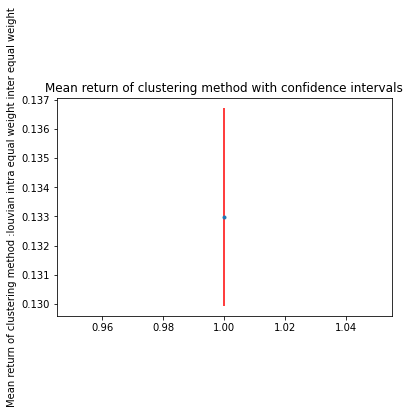

In [14]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

portfolio nb:  0 return:  0.12461577718405947
portfolio nb:  1 return:  0.12462066583885556
portfolio nb:  2 return:  0.14156995182531262
portfolio nb:  3 return:  0.13538660731143448
portfolio nb:  4 return:  0.13108164630015584
portfolio nb:  5 return:  0.134883335237447
portfolio nb:  6 return:  0.1353595711686839
portfolio nb:  7 return:  0.13231161538231873
portfolio nb:  8 return:  0.1341344234730848
portfolio nb:  9 return:  0.1308447821469192
strategy mean:  ([0.12461577718405947, 0.12462066583885556, 0.14156995182531262, 0.13538660731143448, 0.13108164630015584, 0.134883335237447, 0.1353595711686839, 0.13231161538231873, 0.1341344234730848, 0.1308447821469192], [15.350836516530645, 16.66964620100281, 14.359912732167588, 13.632121163894226, 14.436617859268786, 13.566603102032147, 13.47657292068975, 14.809355446394035, 13.747869233520216, 14.682559919808913], [0.00811784928136432, 0.0074759034676667975, 0.009858691655429234, 0.009931441019613062, 0.00907980301050894, 0.009942307

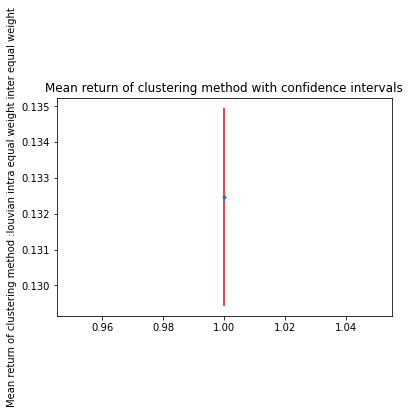

In [15]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))